In [1]:
import pandas as pd

In [2]:
marches = pd.read_csv("https://static.data.gouv.fr/resources/donnees-sur-le-marche-des-jeux-en-ligne-paris-sportifs-hippiques-et-poker-de-2010-a-2024/20251208-095023/open-data-donnees-marche-des-jah-en-ligne-2024.csv", sep=";", encoding="latin-1")

**Description**

Le marché des jeux en ligne s'est ouvert à la concurrence en 2010. Les opérateurs agréés par l'Arjel puis par l'ANJ (Autorité nationale des jeux), depuis sa création en 2020, peuvent proposer des offres de jeux en ligne pour les paris sportifs, les paris hippiques et le poker. La liste des opérateurs agréés est disponible sur le site de l'ANJ. Les opérateurs agréés communiquent régulièrement à l'ANJ les données du marché des jeux en ligne telles que : le nombre de comptes joueurs actifs, les mises, le produit but des jeux (chiffre d'affaires), la répartition des mises se sports, etc.

In [50]:
nb_joueurs = pd.read_csv("https://www.data.gouv.fr/api/1/datasets/r/bee3f217-e4d8-49aa-8985-d66c133de9b0", sep=";", encoding="latin-1")

**Description**

Ce fichier détaille par département la part de joueurs de jeux d'argent en ligne, par segment de jeu, rapportée à sa population adulte en 2024.

In [36]:
interdit = pd.read_csv("https://www.data.gouv.fr/api/1/datasets/r/ac2d4242-4c0f-4415-b88e-558b8e8e5221", sep=";", encoding="latin-1")

**Description**

Répartition géographique des personnes faisant l'objet d'une interdiction volontaire de jeux depuis 2023

L’interdiction volontaire de jeux est une démarche strictement personnelle qui s’effectue en ligne auprès de l’ANJ.

Elle a pour conséquence d’interdire :

d’entrer dans un casino ou un club de jeux,
d’accéder à un site de jeux en ligne agréé par l’ANJ (paris sportifs, paris hippiques et poker),
d’accéder aux jeux de la FDJ et du PMU réalisés avec un compte joueur.

Cette inscription est valable pour une durée de trois ans minimum. Après cette durée, les personnes peuvent demander la levée de cette interdiction.

In [43]:
nb_joueurs.head()

,Région,Numéro du Département,Département,Nombre de Joueurs de Poker,Nombre de joueurs de Paris Hippiques,Nombre de Joueurs de Paris Sportifs,Nombre de Joueurs Uniques tous segments,Population adulte INSEE par Département,Densité Poker,Densité Paris Hippiques,Densité Paris Sportifs
0,Auvergne-Rhône-Alpes,1,Ain,15620,4237,29940,34555,516728,"3,00%","0,80%","5,80%"
1,Hauts-de-France,2,Aisne,12771,6024,25975,30556,402209,"3,20%","1,50%","6,50%"
2,Auvergne-Rhône-Alpes,3,Allier,5890,2757,12239,14689,269774,"2,20%","1,00%","4,50%"
3,Provence-Alpes-Côte dAzur,4,Alpes-de-Haute-Provence,3650,1246,6211,7539,135937,"2,70%","0,90%","4,60%"
4,Provence-Alpes-Côte dAzur,5,Hautes-Alpes,2778,759,4846,5828,115180,"2,40%","0,70%","4,20%"


In [25]:
len(nb_joueurs)

100

In [ ]:
interdit = interdit.drop(columns=[interdit.columns[2], interdit.columns[3], interdit.columns[5]])
interdit = interdit.iloc[2:]
interdit = interdit.iloc[:97] # Il y a des truc bizzares à la fin du fichier
interdit.columns = ['departement', 'nb_interdit_vol_2023', 'nb_interdit_vol_2024']
interdit.head()

,departement,nb_interdit_vol_2023,nb_interdit_vol_2024
2,13,2734,3602
3,59,2605,3435
4,06,2430,3150
5,69,1778,2367
6,83,1734,2300


Il faut checker que les départemens sont les mêmes d'un df à l'autre

In [51]:
# Nettoyer la colonne 'Numéro du Département' dans nb_joueurs
nb_joueurs['Numéro du Département'] = nb_joueurs['Numéro du Département'].replace('20 (anciennement)', '20')
nb_joueurs['Numéro du Département'] = pd.to_numeric(nb_joueurs['Numéro du Département'], errors='coerce')
nb_joueurs['Numéro du Département'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95, 971, 972, 973, 974, 976])

In [48]:
# Convertir la colonne 'departement' d'interdit en numérique
interdit['departement'] = pd.to_numeric(interdit['departement'], errors='coerce')
interdit['departement'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98])

In [52]:
joueurs = nb_joueurs.merge(interdit, left_on='Numéro du Département', right_on='departement', how='outer')

In [ ]:
len(joueurs)

102

## Visualisation des données à l'aide de cartiflette

In [16]:
import cartiflette

In [78]:
from cartiflette import carti_download
shp_communes = carti_download(
      values = ["France"],
      crs = 4326,
      borders = "DEPARTEMENT",
      vectorfile_format="topojson",
      simplification=50,
      filter_by="FRANCE_ENTIERE_DROM_RAPPROCHES",
      source="EXPRESS-COG-CARTO-TERRITOIRE",
      year=2022)

In [89]:
dep = shp_communes[['INSEE_DEP', 'LIBELLE_DEPARTEMENT', 'geometry']].copy()

In [90]:
dep['INSEE_DEP'] = dep['INSEE_DEP'].replace({'2A': '20', '2B': '20'})

In [91]:
dep['INSEE_DEP'] = pd.to_numeric(dep['INSEE_DEP'], errors='coerce')

In [93]:
# Fusionner les polygones de Corse-du-Sud et Haute-Corse
# Enlever les lignes avec des NaN avant de fusionner
dep_clean = dep.dropna(subset=['geometry', 'INSEE_DEP']).copy()

# Fixer les géométries invalides
dep_clean['geometry'] = dep_clean.geometry.make_valid()

# Grouper par INSEE_DEP et fusionner les géométries
dep_clean = dep_clean.dissolve(by='INSEE_DEP', aggfunc='first')

dep_clean.head()

,geometry,LIBELLE_DEPARTEMENT
INSEE_DEP,,
1,"POLYGON ((5.31062 46.44695, 5.31138 46.4459, 5...",Ain
2,"POLYGON ((4.04823 49.40563, 4.04797 49.40419, ...",Aisne
3,"POLYGON ((2.28109 46.42047, 2.28175 46.42068, ...",Allier
4,"POLYGON ((6.94843 44.6548, 6.94817 44.65416, 6...",Alpes-de-Haute-Provence
5,"POLYGON ((6.94843 44.6548, 6.94769 44.65489, 6...",Hautes-Alpes


In [95]:
dep_clean = dep_clean.reset_index()

In [96]:
joueurs_geo = joueurs.merge(dep_clean, left_on='Numéro du Département', right_on='INSEE_DEP', how='outer')

In [97]:
joueurs_geo.head(5)

,Région,Numéro du Département,Département,Nombre de Joueurs de Poker,Nombre de joueurs de Paris Hippiques,Nombre de Joueurs de Paris Sportifs,Nombre de Joueurs Uniques tous segments,Population adulte INSEE par Département,Densité Poker,Densité Paris Hippiques,Densité Paris Sportifs,departement,nb_interdit_vol_2023,nb_interdit_vol_2024,INSEE_DEP,geometry,LIBELLE_DEPARTEMENT
0,Auvergne-Rhône-Alpes,1.0,Ain,15620.0,4237.0,29940.0,34555.0,516728.0,"3,00%","0,80%","5,80%",1.0,518,684,1.0,"POLYGON ((5.31062 46.44695, 5.31138 46.4459, 5...",Ain
1,Hauts-de-France,2.0,Aisne,12771.0,6024.0,25975.0,30556.0,402209.0,"3,20%","1,50%","6,50%",2.0,162,225,2.0,"POLYGON ((4.04823 49.40563, 4.04797 49.40419, ...",Aisne
2,Auvergne-Rhône-Alpes,3.0,Allier,5890.0,2757.0,12239.0,14689.0,269774.0,"2,20%","1,00%","4,50%",3.0,256,337,3.0,"POLYGON ((2.28109 46.42047, 2.28175 46.42068, ...",Allier
3,Provence-Alpes-Côte dAzur,4.0,Alpes-de-Haute-Provence,3650.0,1246.0,6211.0,7539.0,135937.0,"2,70%","0,90%","4,60%",4.0,121,162,4.0,"POLYGON ((6.94843 44.6548, 6.94817 44.65416, 6...",Alpes-de-Haute-Provence
4,Provence-Alpes-Côte dAzur,5.0,Hautes-Alpes,2778.0,759.0,4846.0,5828.0,115180.0,"2,40%","0,70%","4,20%",5.0,72,98,5.0,"POLYGON ((6.94843 44.6548, 6.94769 44.65489, 6...",Hautes-Alpes


In [98]:
# Afficher les lignes avec des NaN
joueurs_geo[joueurs_geo.isna().any(axis=1)]

,Région,Numéro du Département,Département,Nombre de Joueurs de Poker,Nombre de joueurs de Paris Hippiques,Nombre de Joueurs de Paris Sportifs,Nombre de Joueurs Uniques tous segments,Population adulte INSEE par Département,Densité Poker,Densité Paris Hippiques,Densité Paris Sportifs,departement,nb_interdit_vol_2023,nb_interdit_vol_2024,INSEE_DEP,geometry,LIBELLE_DEPARTEMENT
95,NaN,971.0,Guadeloupe,4454.0,6307.0,13940.0,19011.0,296613.0,"1,50%","2,10%","4,70%",NaN,NaN,NaN,971.0,"MULTIPOLYGON (((-4.61985 41.56542, -4.61892 41...",Guadeloupe
96,NaN,972.0,Martinique,3528.0,5824.0,12374.0,16925.0,280890.0,"1,30%","2,10%","4,40%",NaN,NaN,NaN,972.0,"MULTIPOLYGON (((-2.84063 41.72042, -2.84008 41...",Martinique
97,NaN,973.0,Guyane,4458.0,1159.0,13101.0,13950.0,181304.0,"2,50%","0,60%","7,20%",NaN,NaN,NaN,973.0,"MULTIPOLYGON (((-0.84569 42.05054, -0.84824 42...",Guyane
98,NaN,974.0,Réunion,13489.0,13833.0,28382.0,39573.0,644094.0,"2,10%","2,10%","4,40%",NaN,NaN,NaN,974.0,"MULTIPOLYGON (((0.16128 41.64736, 0.16245 41.6...",La Réunion
99,NaN,976.0,Mayotte,1114.0,413.0,3223.0,3516.0,156952.0,"0,70%","0,30%","2,10%",NaN,NaN,NaN,976.0,"MULTIPOLYGON (((1.24289 41.72158, 1.24296 41.7...",Mayotte
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,661,845,NaN,None,NaN
101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.0,15,18,NaN,None,NaN


In [100]:
# Afficher les colonnes disponibles pour voir le nom exact
joueurs_geo.columns

Index(['Région', 'Numéro du Département', 'Département',
       'Nombre de Joueurs de Poker', 'Nombre de joueurs de Paris Hippiques',
       'Nombre de Joueurs de Paris Sportifs',
       'Nombre de Joueurs Uniques tous segments',
       'Population adulte INSEE par Département', 'Densité Poker',
       'Densité Paris Hippiques', 'Densité Paris Sportifs', 'departement',
       'nb_interdit_vol_2023', 'nb_interdit_vol_2024', 'INSEE_DEP', 'geometry',
       'LIBELLE_DEPARTEMENT'],
      dtype='object')

In [121]:
joueurs_geo['nb_interdit_vol_2023'] = pd.to_numeric(joueurs_geo['nb_interdit_vol_2023'], errors='coerce')
joueurs_geo['nb_interdit_vol_2024'] = pd.to_numeric(joueurs_geo['nb_interdit_vol_2024'], errors='coerce')

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd

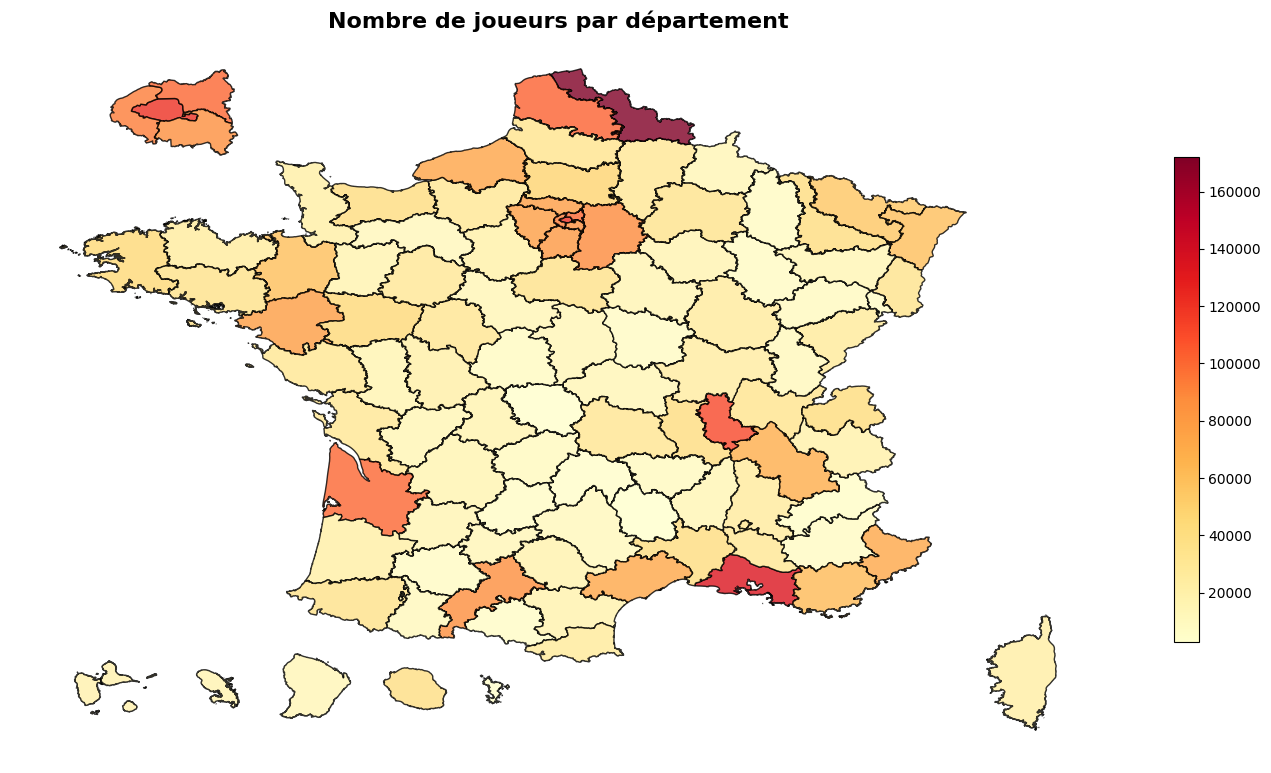

In [110]:
# Créer la carte avec la colonne "Nombre de joueurs de paris sportifs"
fig, ax = plt.subplots(figsize=(14, 10))

# Enlever les NaN pour la visualisation et garder le GeoDataFrame
joueurs_geo_map = joueurs_geo[joueurs_geo['Nombre de Joueurs Uniques tous segments'].notna()].copy()
joueurs_geo_map = gpd.GeoDataFrame(joueurs_geo_map, geometry='geometry')

# Créer la choroplèthe
joueurs_geo_map.plot(
    column='Nombre de Joueurs Uniques tous segments',
    ax=ax,
    legend=True,
    legend_kwds={'shrink': 0.5},
    cmap='YlOrRd',
    edgecolor='k',
    alpha=0.8
)

ax.set_title('Nombre de joueurs par département', fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

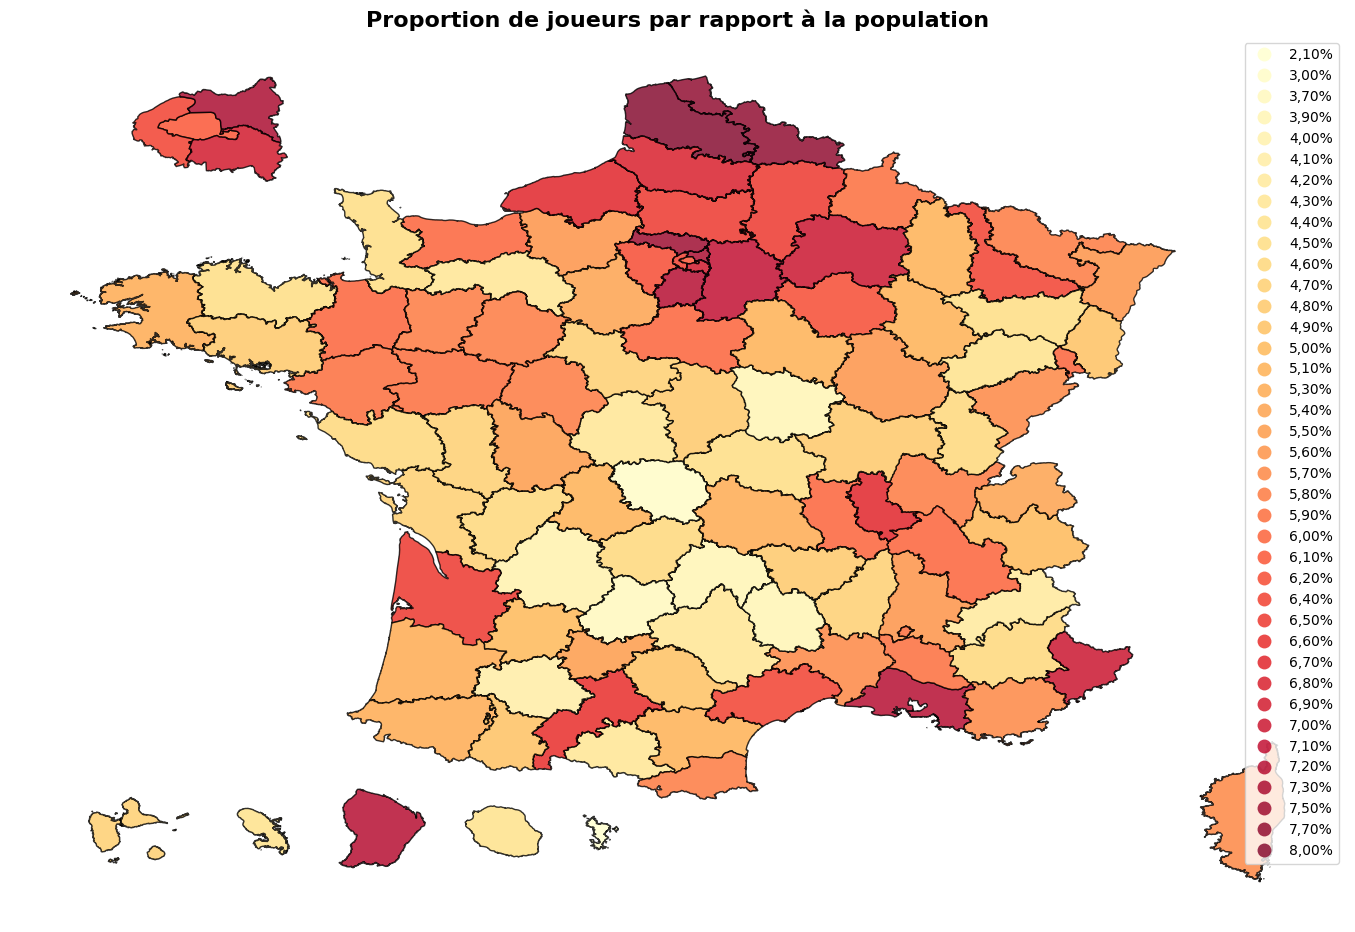

In [ ]:
# Créer la carte avec la colonne "Nombre de joueurs de paris sportifs"
fig, ax = plt.subplots(figsize=(14, 10))

# Enlever les NaN pour la visualisation et garder le GeoDataFrame
joueurs_geo_map = joueurs_geo[joueurs_geo['Densité Paris Sportifs'].notna()].copy()
joueurs_geo_map = gpd.GeoDataFrame(joueurs_geo_map, geometry='geometry')

# Créer la choroplèthe
joueurs_geo_map.plot(
    column='Densité Paris Sportifs',
    ax=ax,
    legend=True,
    cmap='YlOrRd',
    edgecolor='k',
    alpha=0.8
)

ax.set_title('Densité de joueurs', fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

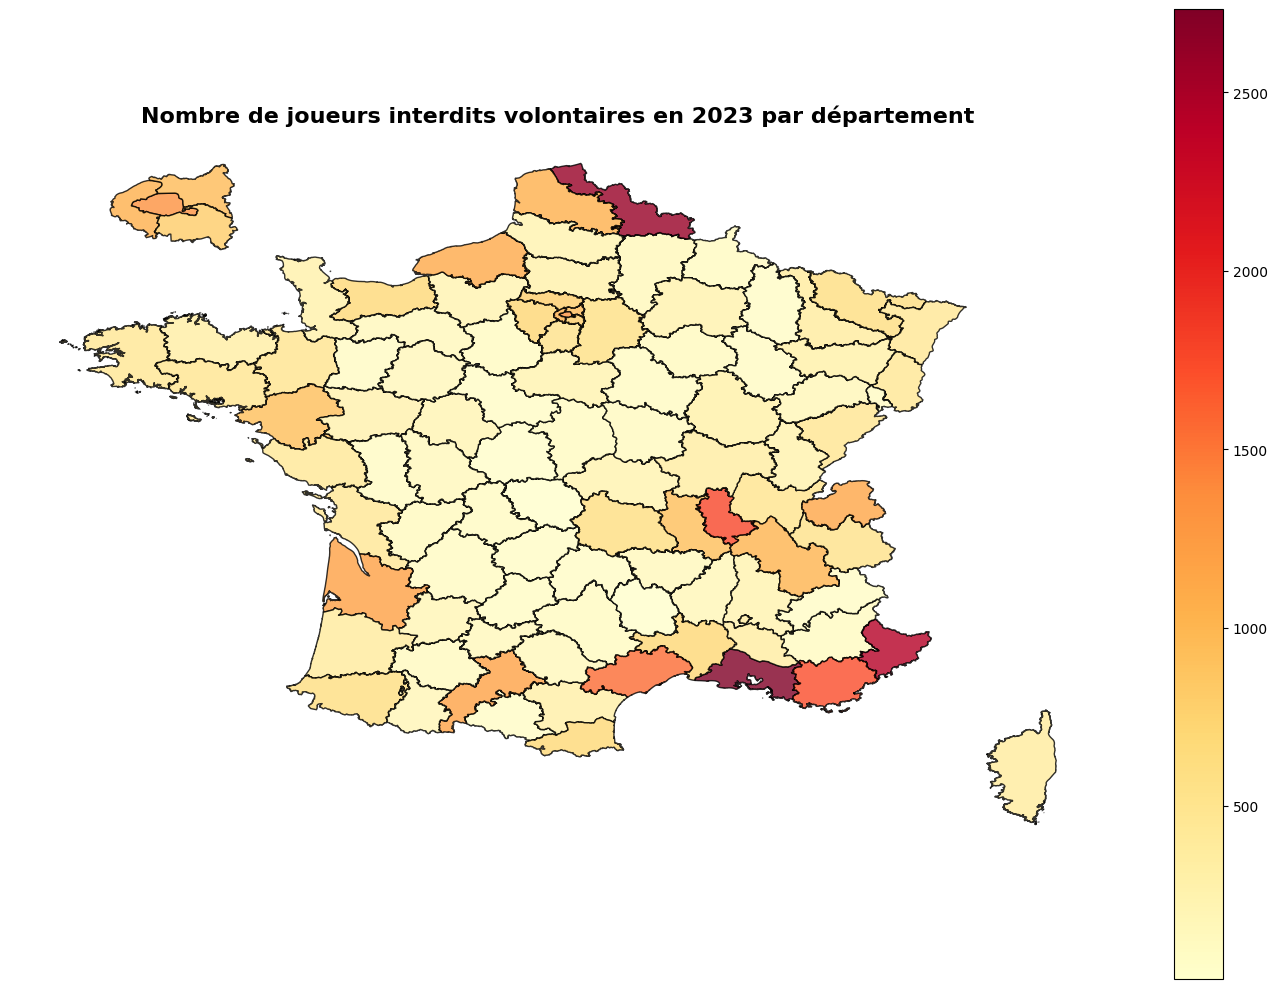

In [122]:
# Créer la carte avec la colonne "Nombre de joueurs de paris sportifs"
fig, ax = plt.subplots(figsize=(14, 10))

# Enlever les NaN pour la visualisation et garder le GeoDataFrame
joueurs_geo_map = joueurs_geo[joueurs_geo['nb_interdit_vol_2023'].notna()].copy()
joueurs_geo_map = gpd.GeoDataFrame(joueurs_geo_map, geometry='geometry')

# Créer la choroplèthe
joueurs_geo_map.plot(
    column='nb_interdit_vol_2023',
    ax=ax,
    legend=True,
    cmap='YlOrRd',
    edgecolor='k',
    alpha=0.8
)

ax.set_title('Nombre de joueurs interdits volontaires en 2023 par département', fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

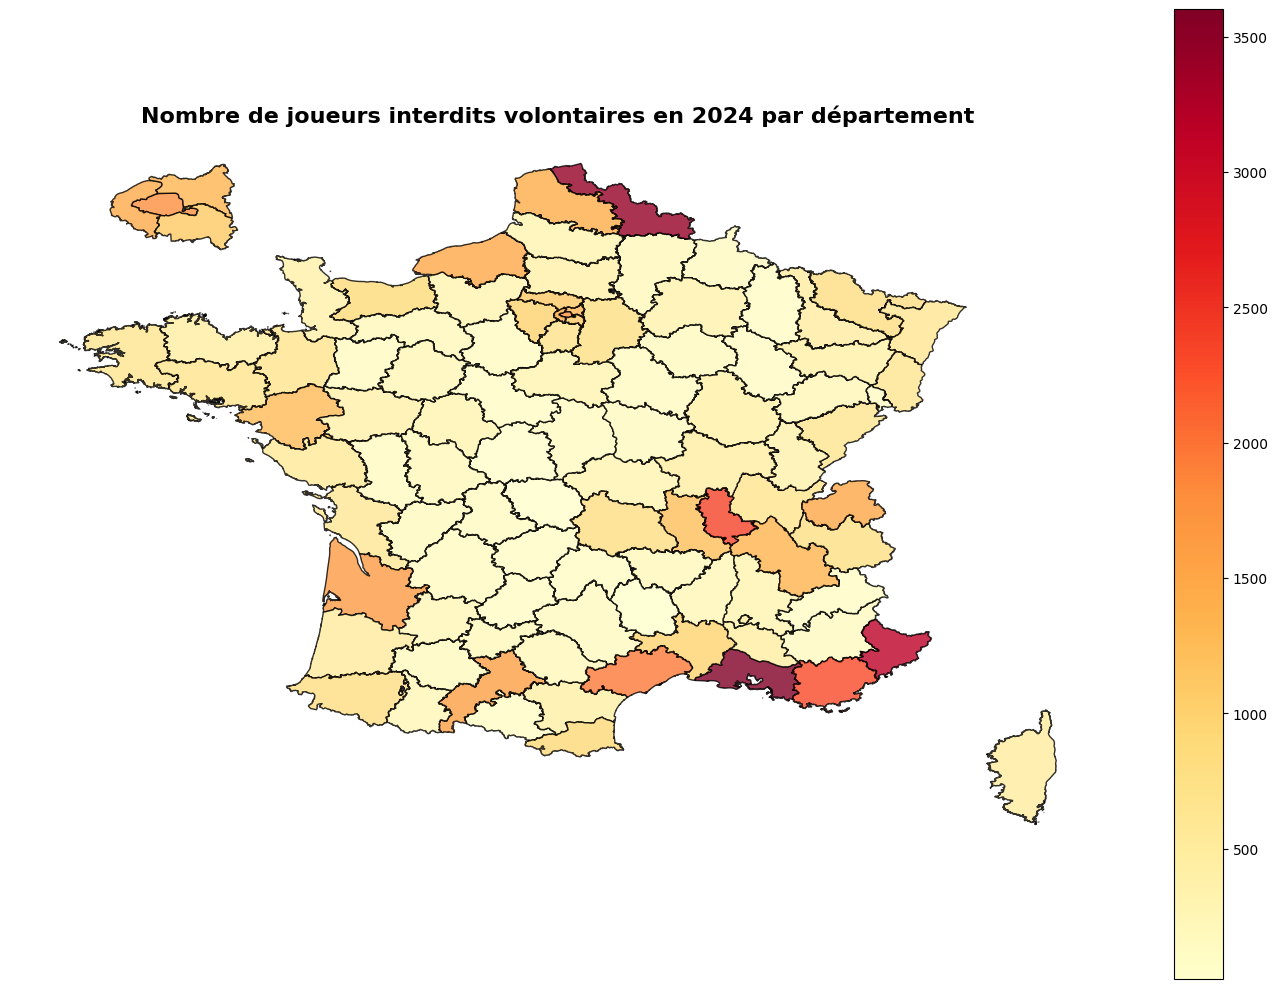

In [123]:
# Créer la carte avec la colonne "Nombre de joueurs de paris sportifs"
fig, ax = plt.subplots(figsize=(14, 10))

# Enlever les NaN pour la visualisation et garder le GeoDataFrame
joueurs_geo_map = joueurs_geo[joueurs_geo['nb_interdit_vol_2024'].notna()].copy()
joueurs_geo_map = gpd.GeoDataFrame(joueurs_geo_map, geometry='geometry')

# Créer la choroplèthe
joueurs_geo_map.plot(
    column='nb_interdit_vol_2024',
    ax=ax,
    legend=True,
    cmap='YlOrRd',
    edgecolor='k',
    alpha=0.8
)

ax.set_title('Nombre de joueurs interdits volontaires en 2024 par département', fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [124]:
joueurs_geo['augm_interdit'] = joueurs_geo['nb_interdit_vol_2024'] / joueurs_geo['nb_interdit_vol_2023'] * 100

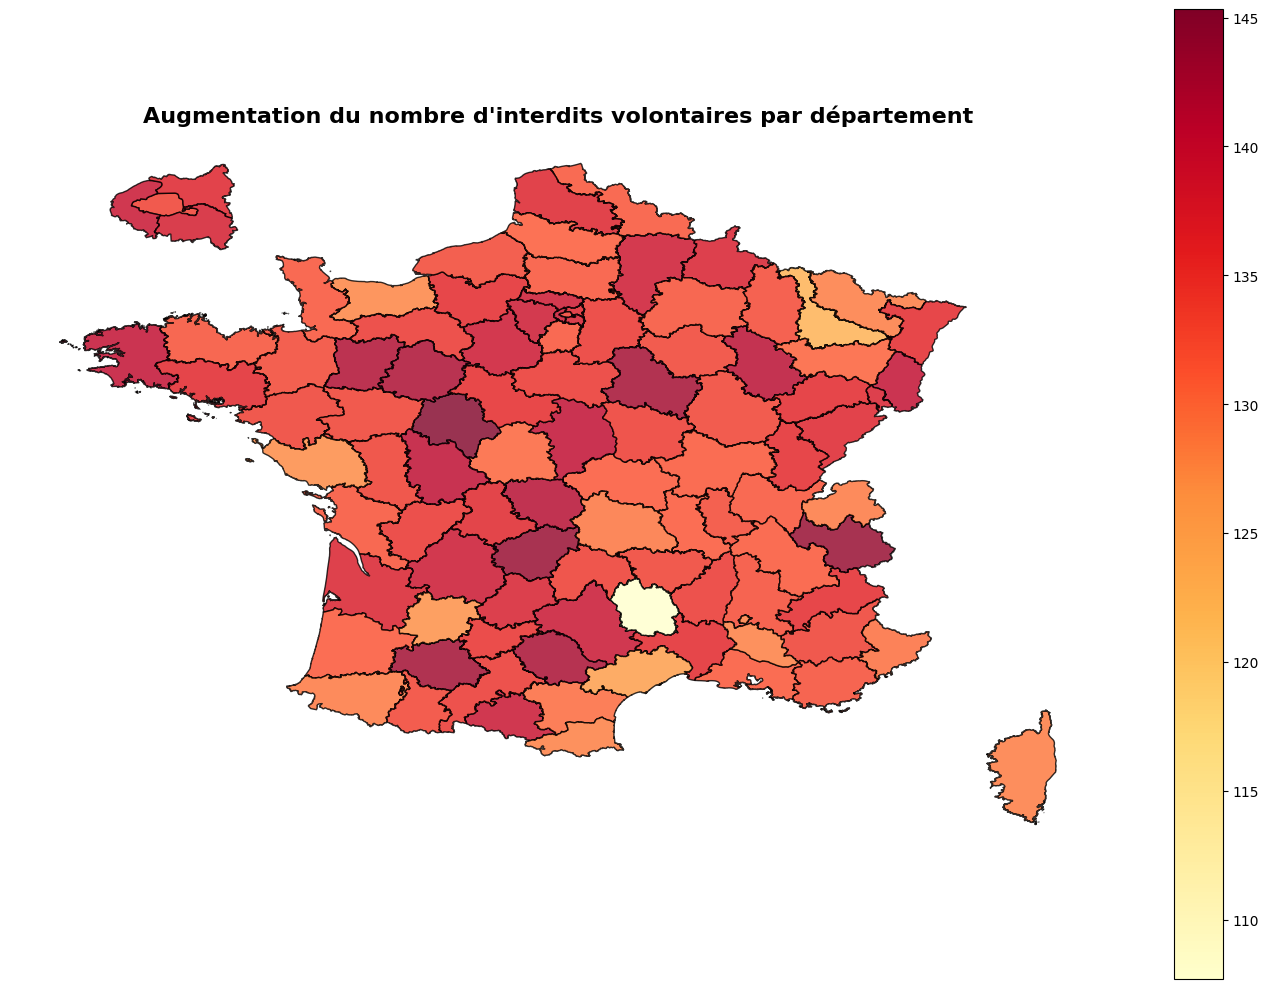

In [126]:
# Créer la carte avec la colonne "Nombre de joueurs de paris sportifs"
fig, ax = plt.subplots(figsize=(14, 10))

# Enlever les NaN pour la visualisation et garder le GeoDataFrame
joueurs_geo_map = joueurs_geo[joueurs_geo['augm_interdit'].notna()].copy()
joueurs_geo_map = gpd.GeoDataFrame(joueurs_geo_map, geometry='geometry')

# Créer la choroplèthe
joueurs_geo_map.plot(
    column='augm_interdit',
    ax=ax,
    legend=True,
    cmap='YlOrRd',
    edgecolor='k',
    alpha=0.8
)

ax.set_title("Augmentation du nombre d'interdits volontaires par département", fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()